In [1]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def LaplacianHPF(height, width):  # Laplacian 滤波器传递函数
    # 拉普拉斯算子：kern = -4*Pi^2*D^2
    u, v = np.mgrid[-1:1:2.0/height, -1:1:2.0/width]
    D = np.sqrt(u**2 + v**2)
    kernel = -4.0 * np.pi**2 * D**2
    # kernel = -4.0 * np.pi**2 * (u**2 + v**2)
    return kernel

In [3]:
def DftFilter(image, D0=10, flag="LaplacianHPF"):  #　最优扩充的快速傅立叶变换
    # (1) DFT 最优尺寸扩充，右侧下侧补 0，(h,w)->(hPad,wPad,2)
    height, width = image.shape[:2]
    hPad = cv.getOptimalDFTSize(height)  # DFT 最优尺寸
    wPad = cv.getOptimalDFTSize(width)
    imgPadded = cv.copyMakeBorder(image, 0, hPad-height, 0, wPad-width, cv.BORDER_CONSTANT)
    # (2) 快速傅里叶变换
    dftImg = cv.dft(imgPadded, flags=cv.DFT_COMPLEX_OUTPUT)  # DFT (hPad,wPad,2)
    # (3) 将低频分量移动到中心
    dftShift = np.fft.fftshift(dftImg)  # (hPad,wPad,2)
    # (4) 构造频域滤波器传递函数
    if flag=="LaplacianHPF":  # 拉普拉斯算子
        filterHP = LaplacianHPF(hPad, wPad)  # Laplacian 传递函数接口
    filterDual = cv.merge([filterHP, filterHP])  # 拼接为2个通道：(hPad,wPad,2)
    # (5) 频率域修改傅里叶变换实现滤波
    dftFiltered = dftShift * filterDual  # 频域滤波 (hPad,wPad,2)
    # (6) 将低频逆移回图像四角，傅里叶逆变换
    iShift = np.fft.ifftshift(dftFiltered)  # 将低频逆转换回图像四角
    # (7) 傅里叶逆变换，使用幅度谱恢复图像
    iDft = cv.idft(iShift)  # 傅里叶逆变换 (hPad,wPad,2)
    iDftMag = cv.magnitude(iDft[:, :, 0], iDft[:, :, 1])  # 重建图像 (hPad,wPad)
    # (8) 截取左上角，转换为 CV_8U
    clipped = iDftMag[:height, :width]  # 切片获得原始图像尺寸 (h,w)
    imgFiltered = np.uint8(cv.normalize(clipped, None, 0, 255, cv.NORM_MINMAX))
    return imgFiltered

In [4]:
# (1) 读取原始图像
img = cv.imread("Fig1001.png", flags=0)  # 灰度图像
imgFloat = img.astype(np.float32)  # 将图像转换成 float32
height, width = img.shape[:2]

In [5]:
# (2) 空间域 拉普拉斯变换
imgSLap = cv.Laplacian(img, -1, ksize=3)

In [6]:
# (3) 频率域 拉普拉斯变换
imgFLap = DftFilter(imgFloat, flag="LaplacianHPF")
logFlap = np.log(1+np.float32(imgFLap))

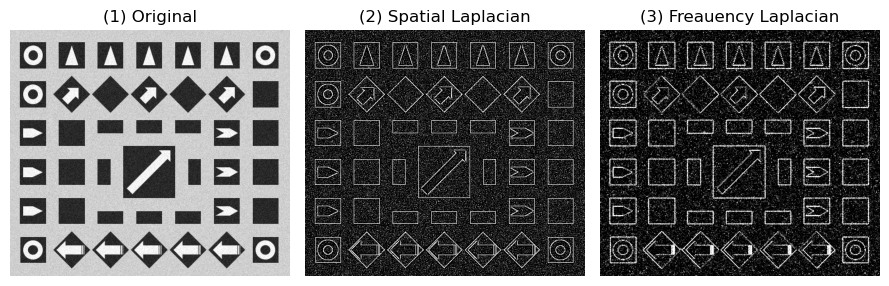

In [7]:
plt.figure(figsize=(9, 3.2))
plt.subplot(131), plt.title("(1) Original")
plt.axis('off'), plt.imshow(img, cmap='gray')
plt.subplot(132), plt.title("(2) Spatial Laplacian")
imgSLap = np.clip(imgSLap,20,255)
plt.axis('off'), plt.imshow(imgSLap, cmap='gray')
plt.subplot(133), plt.title("(3) Freauency Laplacian")
imgFLap = np.clip(imgFLap,20,80)
plt.axis('off'), plt.imshow(imgFLap, cmap='gray')
plt.tight_layout()
plt.show()